### Libraries

In [2]:
# Load Libraries
import os
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
%matplotlib inline

Using TensorFlow backend.


### Preprocessing
1. Import data
2. Label data
3. Split data

In [3]:
# Load images
def load_im():
    input_im, input_label = [], []
    resize = (224, 224)
    # Loop in folders
    for dirname, _, filenames in os.walk('/kaggle/input/pothole-detection-dataset'):
        for filename in filenames:
            photo_path = os.path.join(dirname, filename)
            photo_class = dirname.split('/')[-1]
            try:
                read_im = cv2.imread(photo_path)
                input_im.append(cv2.resize(read_im, resize))
                # potholes == 1
                if photo_class == 'potholes':
                    input_label.append(1)
                # normal == 0
                elif photo_class == 'normal':
                    input_label.append(0)
            except:
                print(photo_path)
    # return list of images and another list of correponding labels
    return input_im, input_label

input_im, input_label = load_im()

/kaggle/input/pothole-detection-dataset/normal/226.jpg


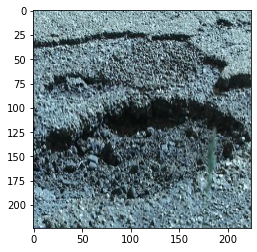

1


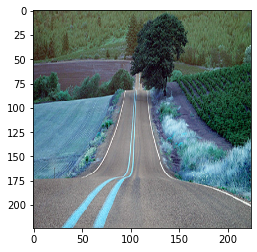

0


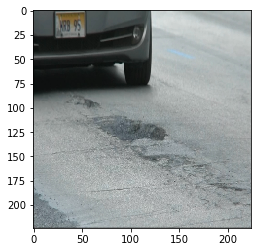

1


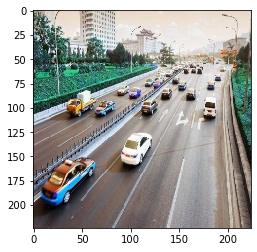

0


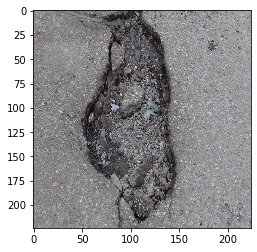

1


In [4]:
# Checking code: Print photo and class
index_set = np.random.choice(len(input_label), size = 5, replace = False)
for index in index_set:
    # show images
    plt.imshow(input_im[index])
    plt.show()
    # show label
    print(input_label[index])

### Image augmentation
Metode yang digunakan
1. Horizontal Flipping
2. Clockwise and Anti-clockwise Rotation by 30 degree

In [5]:
# Train/Test split
def train_test_split(test_prop, input_im, input_label):
    # Random sampling of index
    test_size = int(np.floor(test_prop * len(input_label)))
    test_index = np.random.choice(len(input_label), size = test_size, replace = False)
    # Split
    train_x, test_x, train_y, test_y = np.delete(input_im, test_index, axis = 0), np.take(input_im, test_index, axis = 0), np.delete(input_label, test_index, axis = 0), np.take(input_label, test_index, axis = 0)
    # Return train and test sets for both images and labels
    return train_x, test_x, train_y, test_y, test_index

# 80/20 split for small data set
test_prop = 0.2
train_x, test_x, train_y, test_y, test_index = train_test_split(test_prop, input_im, input_label)

In [6]:
def append_im(input_im, input_label, im_iterator):
    input_label_n = input_label.copy()
    input_im_n = input_im.copy()
    for i in range(len(im_iterator)):
        im = im_iterator[i]
        im = im.astype('uint8')
        im_lbl = [input_label[i]]
        input_im_n = np.append(input_im_n, im, axis = 0)
        input_label_n = np.append(input_label_n, im_lbl, axis = 0)
    return input_im_n, input_label_n

In [7]:
# Flipping
flip_data_generator = ImageDataGenerator(horizontal_flip = True)
im_iterator = flip_data_generator.flow(train_x, batch_size = 1, shuffle = False)
input_im_n, input_label_n = append_im(train_x, train_y, im_iterator)

# Rotation - 30 deg 
#rotate_data_generartor = ImageDataGenerator(rotation_range = 30)
#im_iterator = rotate_data_generartor.flow(train_x, batch_size = 1, shuffle = False)
#input_im_n, input_label_n = append_im(input_im_n, input_label_n, im_iterator)

# Rotation - -30 deg 
#rotate_data_generartor = ImageDataGenerator(rotation_range = 330)
#im_iterator = rotate_data_generartor.flow(train_x, batch_size = 1, shuffle = False)
#input_im_n, input_label_n = append_im(input_im_n, input_label_n, im_iterator)

In [8]:
# Reshape
nx, ny, nz = train_x.shape[1], train_x.shape[2], train_x.shape[3]
train_x_nn, test_x_nn = input_im_n, test_x
train_x = input_im_n.reshape((input_im_n.shape[0], nx * ny * nz)) / 255
test_x = test_x.reshape((test_x.shape[0], nx * ny * nz)) / 255
train_y = input_label_n.reshape((input_label_n.shape[0], 1)) 
test_y = test_y.reshape((test_y.shape[0], 1)) 

 ### Dimensionality Reduction
Since images are of high resolution, input matrix has a high column dimension. So, dimensionality reduction may be useful in this situation. Principal component analysis (PCA) will be employed.

Karena gambar memiliki resolusi tinggi, matriks input memiliki dimensi kolom yang tinggi. Jadi, pengurangan dimensi mungkin berguna dalam metode  ini. Analisis komponen utama (PCA) akan digunakan.

In [9]:
# Dimensionality reduction - Full PCA
im_pca = PCA()
im_pca.fit(train_x)
variance_explained_list = im_pca.explained_variance_ratio_.cumsum()
print(variance_explained_list)

[0.20439531 0.32270498 0.37528578 ... 1.         1.         1.        ]


In [10]:
test_x_pca = im_pca.transform(test_x)
train_x_pca = im_pca.transform(train_x)

### Machine learning models
1. Support vector machine (SVM) - PCA-SVM
2. Logistic regression - Baseline Model
3. Convolutional neural network (CNN) - Modified from AlexNet

In [11]:
# Support vector machine with PCA
def svm_grid_search(C, kernel, train_x, train_y):
    accuracy_score_list = []
    
    for c in C:
        # Model training
        svmClassifier = svm.SVC(C = c, kernel = kernel)
        svmClassifier.fit(train_x, train_y.ravel())
        # Prediction on test set
        pred_y = svmClassifier.predict(train_x)
        # Accuracy
        accuracy = accuracy_score(train_y, pred_y)
        accuracy_score_list.append(accuracy)
        print('Regularization parameters: ', c, 'Accuracy', accuracy)
    
    max_accurarcy_id = accuracy_score_list.index(max(accuracy_score_list))
    return C[max_accurarcy_id] 

C, kernel = [0.1 * i for i in range(1, 30)], 'rbf'
opt_C = svm_grid_search(C, kernel, train_x_pca, train_y)

Regularization parameters:  0.1 Accuracy 0.8400735294117647
Regularization parameters:  0.2 Accuracy 0.8961397058823529
Regularization parameters:  0.30000000000000004 Accuracy 0.9237132352941176
Regularization parameters:  0.4 Accuracy 0.9393382352941176
Regularization parameters:  0.5 Accuracy 0.9494485294117647
Regularization parameters:  0.6000000000000001 Accuracy 0.9558823529411765
Regularization parameters:  0.7000000000000001 Accuracy 0.9641544117647058
Regularization parameters:  0.8 Accuracy 0.9678308823529411
Regularization parameters:  0.9 Accuracy 0.9705882352941176
Regularization parameters:  1.0 Accuracy 0.9770220588235294
Regularization parameters:  1.1 Accuracy 0.9816176470588235
Regularization parameters:  1.2000000000000002 Accuracy 0.9834558823529411
Regularization parameters:  1.3 Accuracy 0.9862132352941176
Regularization parameters:  1.4000000000000001 Accuracy 0.9889705882352942
Regularization parameters:  1.5 Accuracy 0.9917279411764706
Regularization parameter

In [12]:
# Test set
svmClassifier = svm.SVC(C = opt_C, kernel = kernel)
svmClassifier.fit(train_x_pca, train_y.ravel())
pred_y = svmClassifier.predict(test_x_pca)
accuracy = accuracy_score(test_y, pred_y)
print(accuracy)

0.8014705882352942


### SVM with PCA performance
**Model parameters:**

Regularization parameters = 2.9

Kernel = Radial Basis Function


**Test set accuracy: 88.2%**

In [13]:
# Logistic Regression
def Logistic():
    logistic_model = Sequential()
    logistic_model.add(Dense(1, activation = 'sigmoid'))
    return logistic_model

# Compile Model
logistic_model = Logistic()
logistic_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [14]:
# Training Model
logistic_model.fit(train_x, train_y, batch_size = 32, epochs = 50, verbose = 1)

Epoch 1/50
1088/1088 [==============================] - 1s 935us/step - loss: 8.1883 - accuracy: 0.5938
Epoch 2/50
1088/1088 [==============================] - 1s 720us/step - loss: 1.3807 - accuracy: 0.7583
Epoch 3/50
1088/1088 [==============================] - 1s 725us/step - loss: 0.5859 - accuracy: 0.8097
Epoch 4/50
1088/1088 [==============================] - 1s 734us/step - loss: 0.9782 - accuracy: 0.7702
Epoch 5/50
1088/1088 [==============================] - 1s 713us/step - loss: 0.6361 - accuracy: 0.8327
Epoch 6/50
1088/1088 [==============================] - 1s 722us/step - loss: 0.7731 - accuracy: 0.8107
Epoch 7/50
1088/1088 [==============================] - 1s 730us/step - loss: 0.3632 - accuracy: 0.8888
Epoch 8/50
1088/1088 [==============================] - 1s 708us/step - loss: 1.2392 - accuracy: 0.7684
Epoch 9/50
1088/1088 [==============================] - 1s 719us/step - loss: 0.4697 - accuracy: 0.8851
Epoch 10/50
1088/1088 [==============================] - 1s 728u

In [15]:
# Test set
print(logistic_model.metrics_names)
print(logistic_model.evaluate(test_x, test_y, verbose = 0))

['loss', 'accuracy']
[1.3717753247303122, 0.7647058963775635]


### Logistic Classifier Performance
**Test set accuracy: 81.6%**

In [16]:
# Convolutional Neural Network - Modified from AlexNet
def CNN():
    CNN_model = Sequential()
    
    CNN_model.add(Conv2D(filters = 96, input_shape = (224, 224, 3), kernel_size = (11, 11), strides = (4, 4), padding = 'valid'))
    CNN_model.add(Activation('relu'))
    CNN_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    
    CNN_model.add(Conv2D(filters = 256,  kernel_size = (5, 5), strides = (1, 1), padding = 'valid'))
    CNN_model.add(Activation('relu'))
    CNN_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    
    CNN_model.add(Flatten())
    CNN_model.add(Dense(512))
    CNN_model.add(Activation('relu'))
    
    CNN_model.add(Dense(256))
    CNN_model.add(Activation('relu'))
    
    CNN_model.add(Dense(1, activation = 'sigmoid'))
    
    return CNN_model

# Compile Model
cnn_model = CNN()
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 


In [17]:
# Training Model
cnn_model.fit(train_x_nn/255, train_y, batch_size = 256, epochs = 50, verbose = 1)

Epoch 1/50
1088/1088 [==============================] - 29s 26ms/step - loss: 0.9643 - accuracy: 0.4761
Epoch 2/50
1088/1088 [==============================] - 28s 26ms/step - loss: 0.6925 - accuracy: 0.5257
Epoch 3/50
1088/1088 [==============================] - 28s 26ms/step - loss: 0.6730 - accuracy: 0.5616
Epoch 4/50
1088/1088 [==============================] - 32s 30ms/step - loss: 0.6699 - accuracy: 0.5634
Epoch 5/50
1088/1088 [==============================] - 28s 26ms/step - loss: 0.5996 - accuracy: 0.6774
Epoch 6/50
1088/1088 [==============================] - 28s 26ms/step - loss: 0.7335 - accuracy: 0.6075
Epoch 7/50
1088/1088 [==============================] - 28s 26ms/step - loss: 0.6155 - accuracy: 0.5754
Epoch 8/50
1088/1088 [==============================] - 27s 25ms/step - loss: 0.5699 - accuracy: 0.7445
Epoch 9/50
1088/1088 [==============================] - 28s 26ms/step - loss: 0.5521 - accuracy: 0.7482
Epoch 10/50
1088/1088 [==============================] - 28s 26m

In [18]:
print(cnn_model.metrics_names)
print(cnn_model.evaluate(test_x_nn/255, test_y, verbose = 0))

['loss', 'accuracy']
[0.43372275198207183, 0.875]


### CNN Performance
**Test set accuracy: 85.3%**

### Summary
**Test set accuracy: PCA + SVM > CNN > Logistic classifier**

Untuk meningkatkan kinerja, kita dapat menggunakan jaringan yang sudah terlatih / batalkan komentar pada kode augmentasi (rotasi) gambar yang tersisa / mengikis lebih banyak data di situs web.